# Алгоритм маршрутизации для модели присоединения к покрытию

## Сэмплинг графа

Здесь описан алгоритм сэмплинга двумерного графа, но он элементарно обобщается на любую размерность.

Будем пользоваться методом rejection sampling. Добавление вершины в граф выглядит следующим образом:

1.   Генерируется точка из равномерного распределения на прямоугольнике, полностью содержащем покрытие графа
2.   Если эта точка попадает в покрытие, то она добавляется в качестве новой вершины в граф. В противном случае процесс повторяется.

Параметры ограничивающего прямоугольника обновляются при добавлении новой вершины.

Для быстрой проверки того, что точка принадлежит покрытию, предлагается следующая структура данных. Плоскость разбивается на клетки со стороной 1 (в общем случае длина стороны равна радиусу, но без ограничения общности можно положить радиус равным 1), которые являются ключами хэш-таблицы. Значение по ключу -- множество вершин, попадающих в клетку. Проверка, что точка принадлежит покрытию, устроена так: находим клетку, в которую попадает точка, и 8 соседних с ней клеток. Для всех вершин, лежащих в этих клетках, находим расстояние до новой точки. Если расстояние меньше 1 -- добавляем в граф соответствующее ребро. Если хотя бы одно ребро было добавлено, то добавляем вершину в множество вершин графа (это уже формальность, но нужно это явно проговорить).

In [0]:
!pip install networkx
!pip install seaborn==0.9.0

    100% |████████████████████████████████| 215kB 24.1MB/s 
  Found existing installation: seaborn 0.7.1
    Uninstalling seaborn-0.7.1:
      Successfully uninstalled seaborn-0.7.1


In [0]:
import networkx as nx
from math import floor, sqrt, pow
import random
from collections import defaultdict

def generate_coverage_attachment_graph(n, seed=0):
  """
  Algorithm for sampling of coverage attachment graphs
  n: number of vertices
  seed: random seed
  build_cds: boolean, constructs CDS (adds attribute `cds` to vertices)
  """
  # loose input check
  assert n >= 2
  
  # initialize
  random.seed(seed)
  ## graph grows from the origin
  initial_vertex_coordinates = (0, 0)
  coordinates = [initial_vertex_coordinates]
  
  def get_cell_origin(x, y):
    """
    Get bottom-left coordinates of square, containing the point (x, y).
    Bottom and left sides of square are included, top and right are not.
    """
    return floor(x), floor(y)
  
  ## mapping from cell to vertices
  ## vertices are enumerated from 0
  cells = defaultdict(set)
  cells[get_cell_origin(*initial_vertex_coordinates)] = {0}
  
  ## bounding box for sampling
  bbox_xmin = -1
  bbox_xmax = 1
  bbox_ymin = -1
  bbox_ymax = 1
  
  ## the graph itself
  g = nx.Graph()
  g.add_node(0, coordinates=initial_vertex_coordinates)
  
  ## add new vertices
  for t in range(1, n):
    # rejection sampling: generate uniform rv in bounding box until it hits the coverage
    added = False
    x, y = None, None
    while not added:
      x = random.uniform(bbox_xmin, bbox_xmax)
      y = random.uniform(bbox_ymin, bbox_ymax)
      cell = get_cell_origin(x, y)
      cells_to_check = [(cell[0] + dx, cell[1] + dy) for dx in (-1, 0, 1) for dy in (-1, 0, 1)]
      for cell_to_check in cells_to_check:
        vertices = cells.get(cell_to_check, set())
        for v in vertices:
          xv, yv = coordinates[v]
          distance = sqrt(pow(x - xv, 2) + pow(y - yv, 2))
          if distance < 1:
            added = True
            g.add_edge(t, v, distance=distance)
    
    # update current state
    g.add_node(t, coordinates=(x, y))
    coordinates.append((x, y))
    cells[get_cell_origin(x, y)].add(t)
    bbox_xmin = min(bbox_xmin, x - 1)
    bbox_xmax = max(bbox_xmax, x + 1)
    bbox_ymin = min(bbox_ymin, y - 1)
    bbox_ymax = max(bbox_ymax, y + 1)

  return g

Пример геометрического графа, порожденного моделью присоединения к покрытию

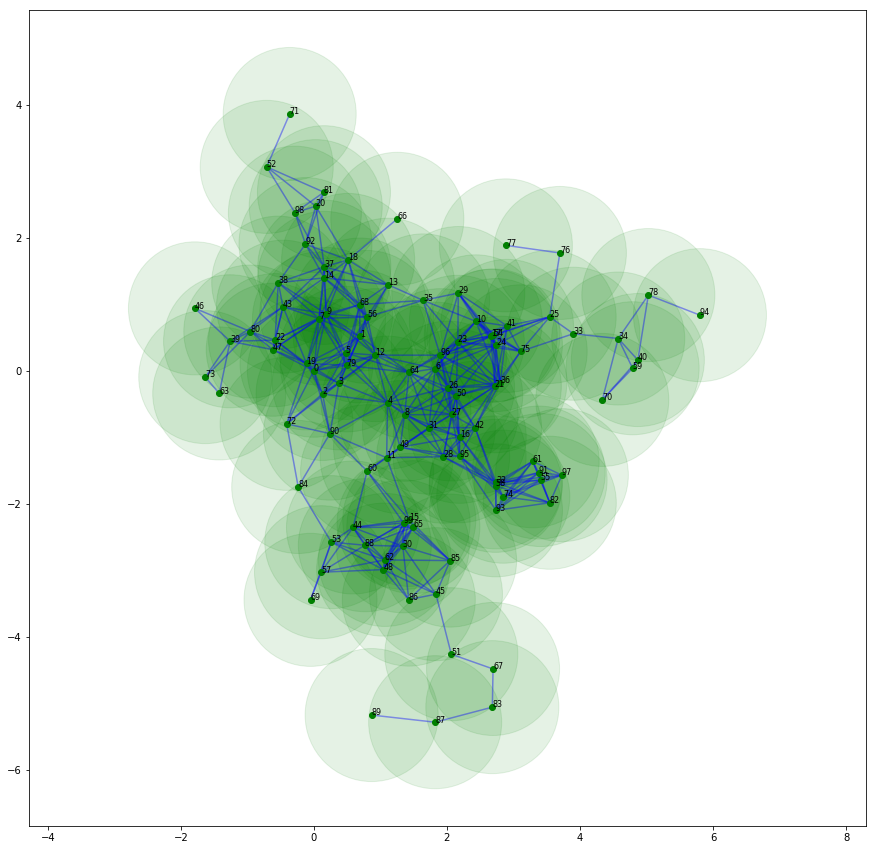

In [0]:
import matplotlib.pyplot as plt
def plot_geometric_graph(g, r=1, vertices=None, edges=None):
  vertices = set(vertices or [])
  edges = set(edges or [])
  fig, ax = plt.subplots(figsize=(15, 15))
  ax.axis('equal')
  for v, d in g.nodes(data=True):
    x, y = d['coordinates']
    color = 'g'
    zorder = 2
    if v in vertices:
      color = 'r'
      zorder = 3
    ax.scatter(x, y, marker='o', color=color, zorder=zorder)
    circle = plt.Circle((x, y), 1, color='g', fill=True, alpha=0.1, zorder=0)
    ax.add_patch(circle)
    ax.annotate(str(v), xy=(x, y), fontsize=8)

  for v1, v2 in g.edges():
    x1, y1 = g.nodes[v1]['coordinates']
    x2, y2 = g.nodes[v2]['coordinates']
    color = 'b'
    zorder = 1
    if (v1, v2) in edges or (v2, v1) in edges:
      color = 'r'
      zorder = 2
    ax.plot((x1, x2), (y1, y2), color=color, zorder=zorder, alpha=0.4)
    
plot_geometric_graph(generate_coverage_attachment_graph(100))

## Алгоритм построения CDS

In [0]:
def build_cds(g, strategy='max_time', seed=0):
  """
  
  strategy: heuristic for CDS algorithm ('random', 'min_time', 'max_time')
  returns networkx graph, nodes have attribute `coordinates`, containing (x, y) tuples
  """
  
  if strategy not in ('random', 'min_time', 'max_time'):
    raise ValueError("Unknown 'strategy': {}".format(cds_strategy))

  random.seed(seed)
  
  cds = set()
  for t in sorted(g.nodes()):
    has_neighbor_in_cds = False
    for n in g.neighbors(t):
      if n in cds:
        has_neighbor_in_cds = True
        break

    if not has_neighbor_in_cds:
      ns = list(g.neighbors(t))
      if strategy == 'random':
        n_to_add = random.choice(ns)
      elif strategy == 'min_time':
        n_to_add = min(ns)
      elif strategy == 'max_time':
        n_to_add = max(ns)
      cds.add(n_to_add)
  
  return cds

Сравним предлагаемые эвристики алгоритма построения CDS между собой, а также с минимальным остовным деревом без листьев. 

In [0]:
def build_cds_mst(g):
  """
  Build CDS using mininum spanning tree
  """
  mst = nx.minimum_spanning_tree(g)

  # return all non-leaf nodes of MST
  return set([n for n in mst.nodes() if mst.degree(n) > 1])

Моделирование проводится следующим образом: для заданного числа вершин (от 1000 до 10000 с шагом в 1000) генерируется 10 случайных реализаций CA, для каждой строятся CDS, затем результаты усредняются по реализациям.

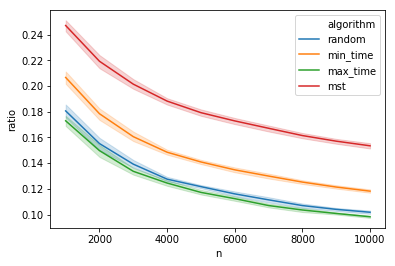

In [0]:
import pandas as pd
import seaborn as sns

n_min = 1000
n_max = 10000
step = 1000
num_trials = 10
measurements = []
for n in range(n_min, n_max+1, step):
  for trial in range(num_trials):
    g = generate_coverage_attachment_graph(n, seed=trial)
    for strategy in ('random', 'min_time', 'max_time'):
      measurements.append((n, trial, strategy, len(build_cds(g, strategy=strategy)) / n))
    measurements.append((n, trial, 'mst', len(build_cds_mst(g)) / n))

df = pd.DataFrame(
    measurements,
    columns=['n', 'trial', 'algorithm', 'ratio']
)

sns.lineplot(x="n", y="ratio", hue="algorithm", data=df)

## Алгоритм жадной геометрической маршрутизации на CDS



Допустим, что в графе $G = (V, E)$ нужно найти путь между вершинами $u$ и $v$. Также заданы:

1. Связное доминирующее множество вершин $D$ (оно может совпадать с множеством всех вершин $V$)
2. Отображение $V \rightarrow \mathbb{R}^d$ из вершин в векторы размерности $d$ (координаты вершин).

Алгоритм жадной геометрической маршутизации реализован ниже:

In [0]:
import numpy as np

def find_greedy_geometric_path(u, v, g, cds, coordinates):
  """
  g: Networkx graph
  u, v: nodes
  cds: set of nodes (must be connected and dominating)
  coordinates: dict {node: (x, y)}
  
  return value: list of nodes in a path between u and v, including u and v (or None, if no path found)
  """
  def d(v1, v2):
    x1, y1 = coordinates[v1]
    x2, y2 = coordinates[v2]
    return sqrt((x1-x2)**2 + (y1-y2)**2)
  
  assert u != v

  # consider only nodes in CDS (or target node itself)
  allowed_nodes = cds | {v}
  path = []
  visited = {u}
  current = u
  while current != v:
    # choose the neighbor node to move to
    ns = (set(g.neighbors(current)) - set(visited)) & allowed_nodes
    
    # all neighbors have been visited, the algorithm gets stuck
    if not ns:
      return None

    ns = list(ns)
    # move to the neighbor closest to the target
    ds = [d(v, n) for n in ns]
    closest = ns[np.argmin(ds)]
    
    # mark left node as visited
    visited.add(current)
    # update path
    path.append(current)
    # move
    current = closest

  path.append(v)
  
  return path


Пример пути, найденного жадным алгоритмом в случае, когда координаты известны точно, а CDS совпадает с множеством всех вершин:

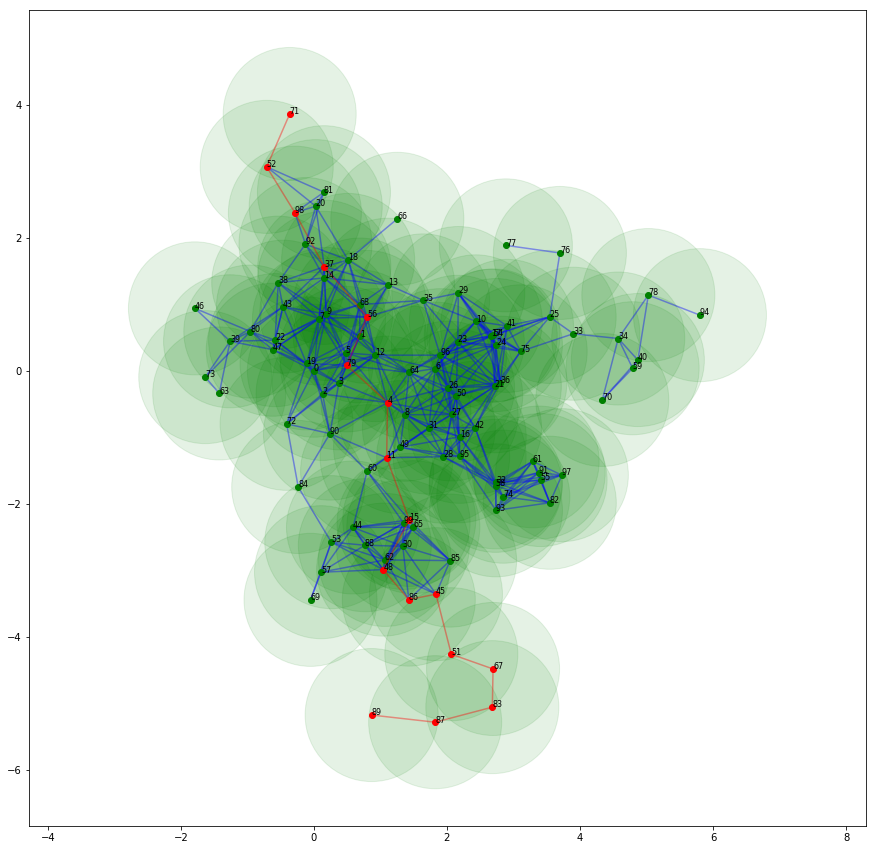

In [0]:
g = generate_coverage_attachment_graph(100)
coordinates = {n: d['coordinates'] for n, d in g.nodes(data=True)}
cds = set(g.nodes())

path = find_greedy_geometric_path(71, 89, g, cds, coordinates)
vertices = None
edges = None
if path:
  vertices = path
  edges = [(path[i], path[i+1]) for i in range(len(path) - 1)]
plot_geometric_graph(g, vertices=vertices, edges=edges)

Исследуем эффективность жадного алгоритма в случае, когда координаты вершин известны неточно.

Поскольку в общем случае алгоритм маршрутизации может не найти пути между парой вершин (в частности, предложенный жадный алгоритм обладает этой особенностью), то нужна метрика качества маршрутизации, которая это учитывает.

Пусть дано множество пар вершин $P \subset V \times V$, между которыми нужно найти пути в графе $G=(V,E)$. Вычислим среднюю гармоническую длину путей $d_{A}$, найденную алгоритмом маршрутизации между парами вершин $(u. v) \in P$. В случае, если алгоритму маршрутизации не удалось найти путь между парой вершин, расстояние между ними считается бесконечным. Также вычислим среднюю гармоническую длину путей $d_{OPT}$, найденную алгоритмом Дейкстры. Ошибкой маршрутизации будем считать $\dfrac{d_{A} - d_{OPT}}{d_{OPT}}$.


In [0]:
import numpy as np
def _compute_harmonic_avg_path_length(paths):
  sum_inv_d = 0
  for path in paths:
    if path is not None:
      sum_inv_d += 1 / (len(path) - 1)
  return len(paths) / sum_inv_d if sum_inv_d else np.inf

def compare_routing_quality(g, pairs, paths1, paths2):
  d_1 = _compute_harmonic_avg_path_length(paths1)
  d_2 = _compute_harmonic_avg_path_length(paths2)
  return (d_1 - d_2) / d_2

Исследуем распределение длин кратчайших путей в модели CA. Исключим из рассмотрения пары вершин, являющиеся рёбрами, поскольку для них любой алгоритм маршрутизации тривиален.

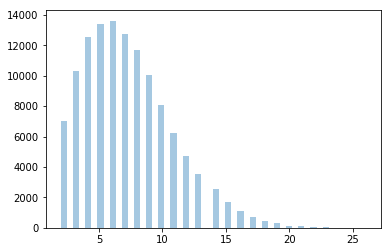

In [0]:
from itertools import combinations

def get_pairs(g, nodes):
  return set(combinations(nodes, 2)) - set(g.edges()) - set([(v2, v1) for v1, v2 in g.edges()])

g = generate_coverage_attachment_graph(500)
pairs = get_pairs(g, g.nodes())
sp = nx.shortest_path(g)
sp_lengths = [len(sp[u][v]) - 1 for u, v in pairs]
sns.distplot(sp_lengths, kde=False)

Видим, что распределение кратчайших путей смещено в сторону малых значений. Поэтому качество маршрутизации, посчитанное по *всем* парам, может оказаться слишком оптимистичным. В связи с этим мы будем считать не только среднее по всем парам, но и среднее по 10% вершин, наиболее удалённым от центра.


In [0]:
def get_far_nodes(g, k):
  coordinates = {n: d['coordinates'] for n, d in g.nodes(data=True)}
  return list(sorted(g.nodes(), key=lambda v: coordinates[v][0]**2 + coordinates[v][1]**2, reverse=True))[:k]

Для разных алгоритмов построения CDS (включая тривиальный, когда CDS совпадает с множеством вершин) исследуем зависимость качества жадной маршрутизации от ошибок в координатах вершин. Ошибки будем моделировать с помощью нормального распределения с нулевым средним.

In [0]:
from collections import defaultdict
import numpy as np
n_min = 100
n_max = 500
step = 100
num_trials = 5

sigmas = [0, 0.1, 0.5]

measurements_all_pairs = defaultdict(list)
measurements_far_pairs = defaultdict(list)

for n in range(n_min, n_max+1, step):
  for sigma in sigmas:
    for trial in range(num_trials):
      g = generate_coverage_attachment_graph(n, seed=trial)
      
      # add noise to true coordinates
      np.random.seed(trial)
      coordinates = {}
      for v, d in g.nodes(data=True):
        x, y = d['coordinates']
        dx, dy = np.random.multivariate_normal([0, 0], [[sigma, 0], [0, sigma]])
        coordinates[v] = (x + dx, y + dy)
        
      # construct pairs
      all_pairs = get_pairs(g, g.nodes())
      far_pairs = get_pairs(g, get_far_nodes(g, n // 10))
      
      # construct various CDS
      cds_mapping = {
          'trivial': set(g.nodes()),
          'random': build_cds(g, strategy='random'),
          'min_time': build_cds(g, strategy='min_time'),
          'max_time': build_cds(g, strategy='max_time'),
          'mst': build_cds_mst(g),
      }
      
      # precompute optimal paths
      shortest_paths = nx.shortest_path(g)
      
      for algorithm, cds in cds_mapping.items():
        all_paths = [
          find_greedy_geometric_path(u, v, g, cds, coordinates)
          for (u, v) in all_pairs
        ]
        all_optimal_paths = [shortest_paths[u][v] for (u, v) in all_pairs]
        all_error = compare_routing_quality(g, all_pairs, all_paths, all_optimal_paths)
        measurements_all_pairs[algorithm].append((n, trial, "sigma="+str(sigma), all_error))
        
        far_paths = [
          find_greedy_geometric_path(u, v, g, cds, coordinates)
          for (u, v) in far_pairs
        ]
        far_optimal_paths = [shortest_paths[u][v] for (u, v) in far_pairs]
        far_error = compare_routing_quality(g, far_pairs, far_paths, far_optimal_paths)
        measurements_far_pairs[algorithm].append((n, trial, "sigma="+str(sigma), far_error))


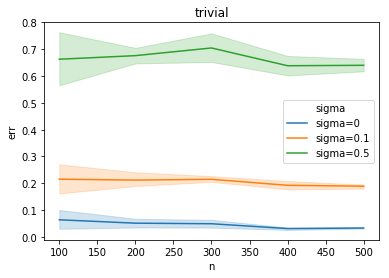

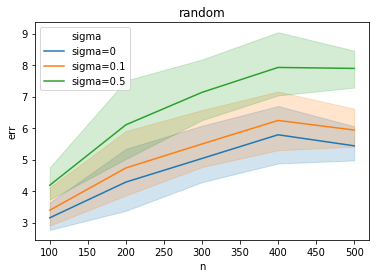

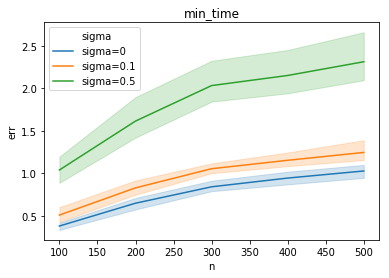

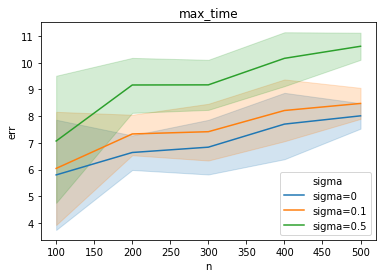

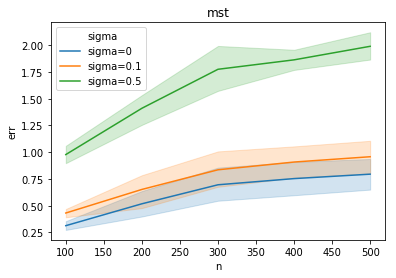

In [0]:
for algorithm, measurements in measurements_all_pairs.items():
  df = pd.DataFrame(
      measurements,
      columns=['n', 'trial', 'sigma', 'err']
  )

  sns.lineplot(x="n", y="err", hue="sigma", data=df).set_title(algorithm)
  plt.show()

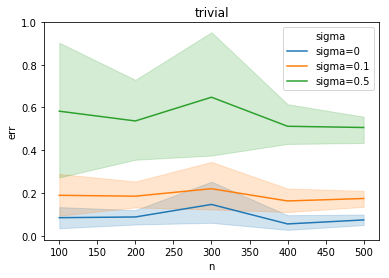

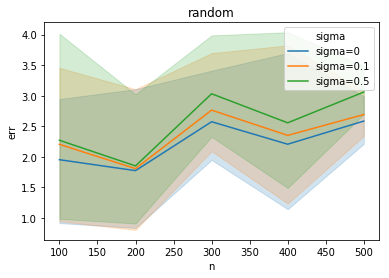

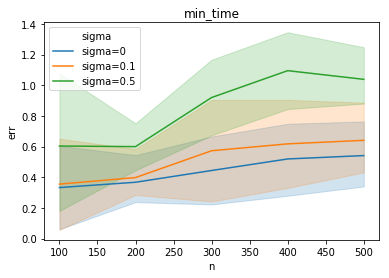

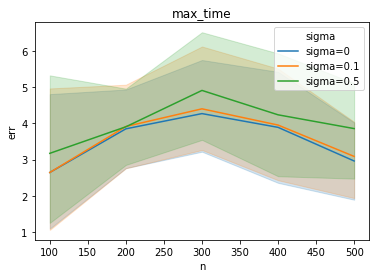

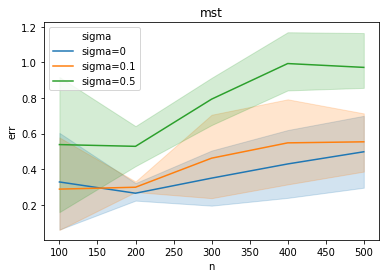

In [0]:
for algorithm, measurements in measurements_far_pairs.items():
  df = pd.DataFrame(
      measurements,
      columns=['n', 'trial', 'sigma', 'err']
  )

  sns.lineplot(x="n", y="err", hue="sigma", data=df).set_title(algorithm)
  plt.show()

In [0]:
 np.random.multivariate_normal([0,0], [[0,0],[0,0]])

array([0., 0.])